In [1]:
%matplotlib inline
import numpy
import numpy as np
import keras

import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, Input, Reshape, Permute, Average
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Lambda, Activation, GlobalAveragePooling2D, Conv2DTranspose, GlobalAveragePooling1D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


# Data loading and preprocessing
### Mostly taken from baseline script given in project description
1. Images -> square patches of fixed size 
2. (?) Extract some features from images

## 0. Problem-specific parameters

In [5]:
NUM_CHANNELS = 3 # RGB images
PIXEL_DEPTH = 255
NUM_LABELS = 2
IMG_SIZE = 400
PATCH_SIZE = 16
WINDOW_SIZE = 32 # 18px - PATCH_SIZE - 18px
NB_WINDOWS = (IMG_SIZE/PATCH_SIZE)**2

## 1. Functions for image pre/post-processing

In [13]:
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        imgs.append(np.asarray(tmp_imgs[i]) / 255)
        '''imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)'''
    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)
    print('Patches per images: ' + str(N_PATCHES_PER_IMAGE))

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]

    data = np.array([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

    return data

# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
    df = numpy.sum(v)
    if df > foreground_threshold:
        return 1 #return [0, 1]
    else:
        return 0 #return [1, 0]

def enhance(train_data):
    #print(len(train_data), train_data[0].shape)
    data_copy = list(train_data)
    
    train_data += [np.rot90(im) for im in data_copy]
    train_data += [np.rot90(im, k=2) for im in data_copy]
    train_data += [np.rot90(im, k=3) for im in data_copy]
    train_data += [np.fliplr(im) for im in data_copy]
    train_data += [np.flipud(im) for im in data_copy]
    train_data += [np.transpose(im, (1,0,2)) for im in data_copy]
    
    del data_copy
    gc.collect()

    return train_data

# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    tmp_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = Image.open(image_filename)
            tmp_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(tmp_imgs)
    for i in range(num_images):
        gt_imgs.append(np.asarray(tmp_imgs[i]) / 255)        
        '''gt_imgs.append(np.asarray(tmp_imgs[i].rotate(90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(180)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].rotate(-90)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_LEFT_RIGHT)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.FLIP_TOP_BOTTOM)) / 255)
        gt_imgs.append(np.asarray(tmp_imgs[i].transpose(Image.TRANSPOSE)) / 255)'''
    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = numpy.array([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = numpy.array([value_to_class(numpy.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(numpy.float32)

# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    array_labels = numpy.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            array_labels[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return array_labels

def img_float_to_uint8(img):
    rimg = img - numpy.min(img)
    rimg = (rimg / numpy.max(rimg) * PIXEL_DEPTH).round().astype(numpy.uint8)
    return rimg

## Generate windows with mirror boundaries

In [23]:
def compute(img_train, train_labels, window_size, patch_size):
    train_data = []
    nb_windows = (IMG_SIZE/patch_size)**2
    for im in img_train:
        w_im = sliding_window(im, window_size, patch_size)
        train_data += w_im
    
    return np.asarray(train_data).reshape((-1, window_size, window_size, 3)), np.asarray(train_labels)

def apply_mirror_boundary_conditions(coord, dim):
    """
    Return the correct coordinate according to mirror boundary conditions
        coord: a coordinate (x or y) in the image
        dim: the length of the axis of said coordinate
    """
    # If the coordinate is outside of the bounds of the axis, take its reflection inside the image
    if coord < 0:
        coord = -coord
    elif coord >= dim:
        coord =  2*(dim-1) - coord % (2*(dim-1))
    # Else, do nothing
    return int(coord)

def get_window(image, window_size, corner_coordinates, patch_size):
    """
    Get a window in image, centered on a patch, taking into account boundary conditions
        image: a numpy array representing our image
        window_size: an even number specifying the size of the window
        corner_coordinates: a list containing the x-y coordinates of the patch's upleft pixel
        path_size: an even number specifying the size of the central patch
    """
    # Get convenient variables
    window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    nrows, ncols, nchannels = image.shape
    window = np.zeros((window_size, window_size, nchannels))
    
    # Fill in the window array with pixels of the image
    for i in range(window_size):
        # Apply mirror boundary conditions on the x-coordinate
        i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i, nrows)
        for j in range(window_size):
            # Same for the y-coordinate
            j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j, ncols)
            # Fill in the window with the corresponding pixel
            window[i, j, :] = image[i_mirrored, j_mirrored, :]
    return window
def shift_to_the_right(image, window, corner_coordinates, patch_size):
    nrows, ncols, _ = image.shape
    window_size = len(window)
    #window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    step = patch_size
    
    shifted = np.roll(window, -step, axis=1)
    for i in range(window_size):
        i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i, nrows)            
        for j in range(window_size-step, window_size):
            j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j + step, ncols)
            shifted[i, j, :] = image[i_mirrored, j_mirrored, :]
    return shifted

def shift_to_the_bottom(image, window, corner_coordinates, patch_size):
    nrows, ncols, _ = image.shape
    window_size = len(window)
    #window_radius = window_size/2
    border_size = (window_size - patch_size)/2
    i_patch_corner, j_patch_corner = (corner_coordinates[0], corner_coordinates[1])
    i_window_corner, j_window_corner = (i_patch_corner - border_size, j_patch_corner - border_size)
    step = patch_size
    
    shifted = np.roll(window, -step, axis=0)
    for j in range(window_size):
        j_mirrored = apply_mirror_boundary_conditions(j_window_corner + j, ncols)
        for i in range(window_size-step, window_size):
            i_mirrored = apply_mirror_boundary_conditions(i_window_corner + i + step, nrows)
            shifted[i, j, :] = image[i_mirrored, j_mirrored, :]
    return shifted

def sliding_window(image, window_size, patch_size):
    """
    Construct a list of sliding windows of given size on an image.
    The windows, centered on a patch, will slide from left to right and from up to down.
        image: a numpy array representing our image
        window_size: an even number specifying the size of the window
        patch_size: the size of the central patch
    """
    nrows, ncols, _ = image.shape
    windows = []
    i = 0
    row_windows = [get_window(image, window_size, [i, 0], patch_size)]
    for j in range(patch_size, ncols-1, patch_size):
        #print(j)
        row_windows += [shift_to_the_right(image, row_windows[-1], [i, j], patch_size)]
    windows += row_windows
    #print('===')
    for i in range(patch_size, nrows-1, patch_size):
        #print(i)
        row_windows = [shift_to_the_bottom(image, row_windows[int(j/patch_size)], [i, j], patch_size) 
                       for j in range(0, ncols-1, patch_size)]
        #print(len(row_windows))
        windows += row_windows
    return windows

## 3. Load images from dataset, convert to inputs for model

Model parameters

In [10]:
IMG_PATCH_SIZE = 16
TRAINING_SIZE = 100
BATCH_SIZE = 32
NUM_EPOCHS = 15
a = 0.00

In [11]:
data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)

Loading training/images/satImage_001.png
Loading training/images/satImage_002.png
Loading training/images/satImage_003.png
Loading training/images/satImage_004.png
Loading training/images/satImage_005.png
Loading training/images/satImage_006.png
Loading training/images/satImage_007.png
Loading training/images/satImage_008.png
Loading training/images/satImage_009.png
Loading training/images/satImage_010.png
Loading training/images/satImage_011.png
Loading training/images/satImage_012.png
Loading training/images/satImage_013.png
Loading training/images/satImage_014.png
Loading training/images/satImage_015.png
Loading training/images/satImage_016.png
Loading training/images/satImage_017.png
Loading training/images/satImage_018.png
Loading training/images/satImage_019.png
Loading training/images/satImage_020.png
Loading training/images/satImage_021.png
Loading training/images/satImage_022.png
Loading training/images/satImage_023.png
Loading training/images/satImage_024.png
Loading training

In [12]:
train_data.shape, train_labels.shape

((62500, 16, 16, 3), (62500,))

Image size = 16,16


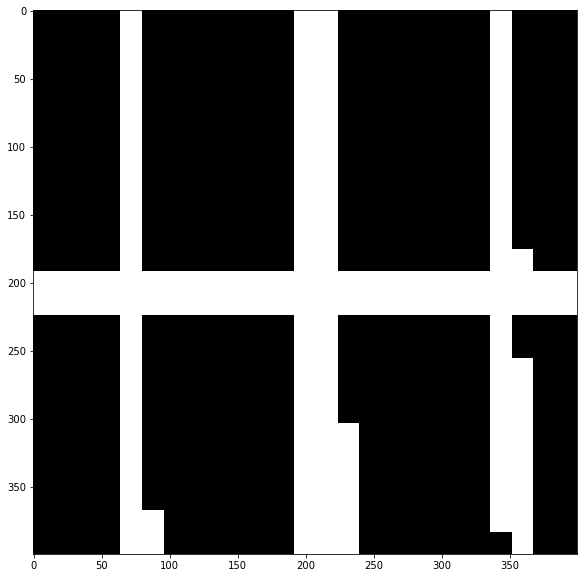

In [14]:
print('Image size = ' + str(train_data[0].shape[0]) + ',' + str(train_data[0].shape[1]))

# Show first image and its groundtruth image
cimg = label_to_img(400, 400, 16, 16, train_labels[:,])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [25]:
imgs, labels = compute(train_data, train_labels, WINDOW_SIZE, PATCH_SIZE)

NameError: name 'img' is not defined

In [26]:
imgs.shape, labels.shape

((62500, 32, 32, 3), (62500,))

## Different ConvNet-based models

In [15]:
INPUT_SIZE = WINDOW_SIZE

#### Simple VGG-like ConvNet (gives ~84% acc, maybe longer training gives extra 2-3%) 

In [73]:
model = Sequential()
model.add(Conv2D(32, 2, input_shape=(INPUT_SIZE, INPUT_SIZE, NUM_CHANNELS)))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 2))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(64, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(LeakyReLU(alpha=a))
model.add(Dense(1, activation='sigmoid'))

#### SqueezeNet-like model

In [75]:
from keras.engine.topology import Layer
def fire(x, squeeze, expand):
    x = Conv2D(squeeze, 1)(x)
    x = LeakyReLU(alpha=a)(x)
    e11 = Conv2D(expand, 1)(x)
    e11 = LeakyReLU(alpha=a)(e11)
    e33 = Conv2D(expand, 1)(x)
    e33 = LeakyReLU(alpha=a)(e33)
    return Concatenate(axis=3)([e11, e33])

In [78]:
inputs = Input(shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS))
x = Conv2D(32, kernel_size=3, strides=2, input_shape=(IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS))(inputs)
x = LeakyReLU(alpha=a)(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

x = fire(x, squeeze=8, expand=16)
x = fire(x, squeeze=8, expand=16)
x = MaxPooling2D(pool_size=3, strides=2)(x)

'''x = fire(x, squeeze=32, expand=128)
x = fire(x, squeeze=32, expand=128)
x = MaxPooling2D(pool_size=3, strides=2)(x)

x = fire(x, squeeze=48, expand=192)
x = fire(x, squeeze=48, expand=192)
x = fire(x, squeeze=64, expand=256)
x = fire(x, squeeze=64, expand=256)
x = MaxPooling2D(pool_size=3, strides=2)(x)'''
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

#### FCN (again, from tutorial network)

In [20]:
model = Sequential()
model.add(Conv2D(32, 2, input_shape=(INPUT_SIZE, INPUT_SIZE, NUM_CHANNELS)))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(32, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 2))
model.add(LeakyReLU(alpha=a))
model.add(Conv2D(64, 2))
model.add(LeakyReLU(alpha=a))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(2, 1))
model.add(Conv2DTranspose(1, kernel_size=IMG_PATCH_SIZE - 1, padding='valid'))
#model.add(Reshape((-1, IMG_PATCH_SIZE * IMG_PATCH_SIZE)))
#model.add(Permute((2,1)))
model.add(GlobalAveragePooling2D())
model.add(Activation('sigmoid'))

## Print model structure

In [21]:
for layer in model.layers:
    print(layer.input_shape,layer.output_shape )

(None, 32, 32, 3) (None, 31, 31, 32)
(None, 31, 31, 32) (None, 31, 31, 32)
(None, 31, 31, 32) (None, 30, 30, 32)
(None, 30, 30, 32) (None, 30, 30, 32)
(None, 30, 30, 32) (None, 15, 15, 32)
(None, 15, 15, 32) (None, 15, 15, 32)
(None, 15, 15, 32) (None, 14, 14, 64)
(None, 14, 14, 64) (None, 14, 14, 64)
(None, 14, 14, 64) (None, 13, 13, 64)
(None, 13, 13, 64) (None, 13, 13, 64)
(None, 13, 13, 64) (None, 6, 6, 64)
(None, 6, 6, 64) (None, 6, 6, 64)
(None, 6, 6, 64) (None, 6, 6, 2)
(None, 6, 6, 2) (None, 20, 20, 1)
(None, 20, 20, 1) (None, 1)
(None, 1) (None, 1)


Optimization

In [33]:
LR = 0.001
DECAY = 0.00000
adam = Adam(lr=LR, decay=DECAY)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

model.fit(imgs, labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/15
62500/62500 [==============================] - 153s - loss: 0.4958 - acc: 0.7587   
Epoch 2/15
62500/62500 [==============================] - 150s - loss: 0.4162 - acc: 0.7979   
Epoch 3/15
62500/62500 [==============================] - 150s - loss: 0.3961 - acc: 0.8087   
Epoch 4/15
62500/62500 [==============================] - 158s - loss: 0.3874 - acc: 0.8152   
Epoch 5/15
62500/62500 [==============================] - 155s - loss: 0.3790 - acc: 0.8201   
Epoch 6/15
62500/62500 [==============================] - 155s - loss: 0.3703 - acc: 0.8263   
Epoch 7/15
62500/62500 [==============================] - 152s - loss: 0.3629 - acc: 0.8304   
Epoch 8/15
62500/62500 [==============================] - 152s - loss: 0.3597 - acc: 0.8329   
Epoch 9/15
62500/62500 [==============================] - 153s - loss: 0.3541 - acc: 0.8387   
Epoch 10/15
62500/62500 [==============================] - 158s - loss: 0.3486 - acc: 0.8401   
Epoch 11/15
62500/62500 [========================

In [35]:
score = model.evaluate(imgs, labels)
score

62496/62500 [============================>.] - ETA: 0s

[0.32737596779452266, 0.85761600000000004]

In [36]:
model.save('FCN_W32_noenh.h5')

## Test predictions

In [63]:
import re

def extract_test_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    names = []
    for i in range(1, num_images+1):
        imageid = "test_{}/test_{}".format(i,i)
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
            names.append(image_filename)
        else:
            print ('File ' + image_filename + ' does not exist')
    return np.array(imgs), names

# Get prediction for given input image 
def keras_prediction(model, img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    output_prediction = model.predict(data)
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(im, im_name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", im_name).group(0))
    for j in range(0, im.shape[1], IMG_PATCH_SIZE):
        for i in range(0, im.shape[0], IMG_PATCH_SIZE):
            patch = im[i:i + IMG_PATCH_SIZE, j:j + IMG_PATCH_SIZE]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, images, images_names):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for ind, fn in enumerate(images):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, images_names[ind]))

In [64]:
TEST_SIZE = 50
test_data_dir = 'test_set_images/'

# Extract it into numpy arrays.
test_data, file_names = extract_test_data(test_data_dir, TEST_SIZE)

In [139]:
test_data.shape

(50, 608, 608, 3)

In [140]:
submission_filename = 'silly_submission.csv'
images = [keras_prediction(model, test_data[i]) for i in range(test_data.shape[0])]
masks_to_submission(submission_filename, images, file_names)

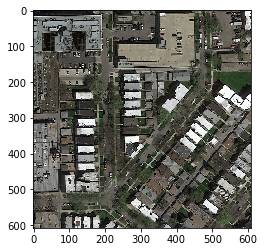

In [141]:
plt.imshow(test_data[3])

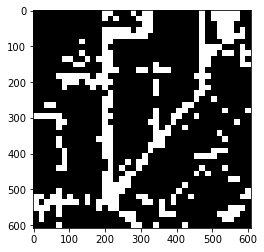

In [142]:
tmp_data = numpy.asarray(img_crop(test_data[3], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = model.predict(tmp_data)
plt.imshow(label_to_img(608, 608, 16, 16, output_prediction), cmap='Greys_r')

## Random things testing....

In [85]:
def label_to_img_lr(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

In [73]:
from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(train_data.reshape((train_data.shape[0], -1)), np.argmax(train_labels, axis=1))

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [193]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, logreg.predict(train_data.reshape((train_data.shape[0], -1))))

0.55457599999999996

In [78]:
tmp_data = numpy.asarray(img_crop(test_data[0], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = logreg.predict(tmp_data.reshape(tmp_data.shape[0], -1))
plt.imshow(label_to_img_lr(608, 608, 16, 16, output_prediction), cmap='Greys_r')

## MLP from sklearn

In [196]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 64))
mlp.fit(train_data.reshape((train_data.shape[0], -1)), train_labels)
accuracy_score(train_labels, mlp.predict(train_data.reshape((train_data.shape[0], -1))))

0.79867200000000005

In [181]:
def sklearn_prediction(model, image):
    tmp_data = numpy.asarray(img_crop(image, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    output_prediction = model.predict(tmp_data.reshape(tmp_data.shape[0], -1))
    return label_to_img_lr(608, 608, 16, 16, output_prediction)

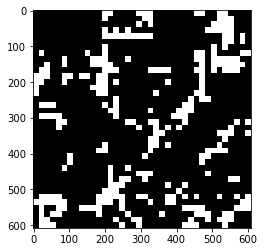

In [182]:
tmp_data = numpy.asarray(img_crop(test_data[3], IMG_PATCH_SIZE, IMG_PATCH_SIZE))
output_prediction = mlp.predict(tmp_data.reshape(tmp_data.shape[0], -1))
plt.imshow(label_to_img_lr(608, 608, 16, 16, output_prediction), cmap='Greys_r')